In [1]:
import urllib.request
import json
from tqdm.notebook import tqdm_notebook
from graphviz import Digraph

In [ ]:
memory = {}

In [35]:
def GetReferences(semantic_id, arxiv, depth, top_n=10):
    print(depth)
    if semantic_id in memory:
        data = memory[semantic_id]
    else:
        link = 'http://api.semanticscholar.org/v1/paper/{}'.format('arXiv:' + semantic_id if arxiv else semantic_id)

        with urllib.request.urlopen(link) as paper:
            data = json.loads(paper.read().decode())
        memory[data['paperId']] = data
        
    papers[data['paperId']] = {'title': data['title'],
                               'references': [{'paperId': reference['paperId'], 'title': reference['title']} for reference in data['references']] if depth > 2 else [],
                               'citations': len(data['citations'])}
    
    # Problem to fix. After going one layer down, you want to prune articles that don't fit the top_n. This will lead to top_n^depth time
    # Right now, we have ~avg_n^depth time, as we exhaustively search through every reference's reference.
    # Every depth%2==0 (Even), prune references not appearing above. Would have to be breadth wise
    
    if depth > 2:
        citations = {}
        for reference in tqdm_notebook(papers[data['paperId']]['references']):
            citations[reference['paperId']] = GetCitations(reference['paperId'])
        
        if len(citations) > top_n:
            citations = sorted(citations, key=lambda x: x[1], reverse=True)
            if top_n != -1:
                citations = citations[:top_n]
        
        papers[data['paperId']]['references'] = [reference for reference in papers[data['paperId']]['references'] if reference['paperId'] in citations]

        for reference in tqdm_notebook(papers[data['paperId']]['references']):
            GetReferences(reference['paperId'], False, depth-1, top_n)
            reference['citations'] = papers[reference['paperId']]['citations']
            
        #if len(papers[data['paperId']]['references']) > top_n:
        #    if top_n != -1:
        #        papers[data['paperId']]['references'] = sorted(papers[data['paperId']]['references'], key=lambda x: x['citations'], reverse=True)[:top_n]
        #    else:
        #        papers[data['paperId']]['references'] = sorted(papers[data['paperId']]['references'], key=lambda x: x['citations'], reverse=True)

In [36]:
def GetCitations(reference_id):
    if reference_id in memory:
        data = memory[reference_id]
    else:
        link = 'http://api.semanticscholar.org/v1/paper/{}'.format(reference_id)

        with urllib.request.urlopen(link) as paper:
            data = json.loads(paper.read().decode())
        memory[reference_id] = data
        
    return len(data['citations'])

In [37]:
# e8961cfbb73313b01f2b768650d8851a015e8d18
# a9b80b3cffb758bea670220fa6762eb343865419

In [40]:
papers = {}
GetReferences('2001.09977', True, 4, 5)
root = next(iter(papers))

4


3


2
2
2
2
2

3


2
2
2
2
2

3


2
2
2
2
2

3


2
2
2
2
2

3


2
2
2
2
2




In [42]:
def CleanTree(root): # Assuming that this works. Can not fully test, as depth 4 is too large as of yet
    for ref in papers[root]['references']:
        refs.append(ref['paperId'])
        CleanTree(ref['paperId'])

In [43]:
refs = []
CleanTree(root) # First element
papers = dict(filter(lambda x: x[0] in refs or x[0] == root, papers.items()))

In [44]:
# Graph

In [45]:
dot = Digraph()

for paper_id in papers.keys():
    dot.node(paper_id, papers[paper_id]['title'])
    
for paper_id in papers.keys():
    for reference in papers[paper_id]['references']:
        if reference['paperId'] in papers.keys() and papers[reference['paperId']]['citations'] > 0:
            dot.edge(paper_id, reference['paperId'])

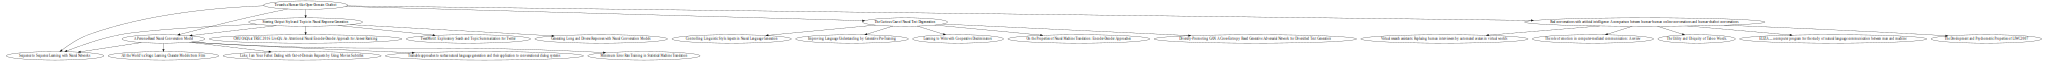

In [46]:
dot

In [2]:
# Get PDF UNUSED

In [6]:
arxiv_id = '2001.09977v2'
link = 'https://arxiv.org/pdf/{}.pdf'.format(arxiv_id)

In [8]:
urllib.request.urlretrieve(link, 'papers/{}.pdf'.format(arxiv_id))

('papers/2001.09977v2.pdf', <http.client.HTTPMessage at 0x28ddfdbfd88>)